##Problem Statement

To diagnose plant diseases based on leaf images. Solving this problem is important because diagnosing plant diseases early can save tonnes of agricultural produce every year. This will benefit not only the general population by reducing hunger, but also the farmers by ensuring they get the harvest they deserve.

## Introduction

Diseases in plants cause major production and economic losses as well as reduction in both quality and quantity of agricultural products. Now a day’s plant diseases detection has received increasing attention in monitoring large field of crops. Farmers experience great difficulties in switching from one disease control policy to another. The naked eye observation of experts is the traditional approach adopted in practice for detection and identification of plant diseases. This simple plant leaves disease detection system would facilitate advancements in agriculture. Early information on crop health and disease detection can facilitate the control of diseases through proper management strategies. This technique will improve productivity of crops

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import tensorflow as tf
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
!unzip -uq "/content/drive/My Drive/Data/plant.zip" -d "/content/drive/My Drive/Data/plant"

In [ ]:
os.listdir('/content/drive/My Drive/Data/plant')

['train.csv', 'test.csv', 'images']


### Load the data and define hyperparameters

In [ ]:
EPOCHS = 20
SAMPLE_LEN = 100
IMAGE_PATH = "/content/drive/My Drive/Data/plant/images/"
TEST_PATH = "/content/drive/My Drive/Data/plant/test.csv"
TRAIN_PATH = "/content/drive/My Drive/Data/plant/train.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [ ]:
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


In [ ]:
train= train_data
test= test_data
train['image_id']=train['image_id']+'.jpg'
test['image_id']=test['image_id']+'.jpg'
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0


In [ ]:
target = train[['healthy', 'multiple_diseases', 'rust', 'scab']]
test_ids = test['image_id']

train_len = train.shape[0]
test_len = test.shape[0]

train.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [ ]:

print("Shape of train data: " + str(train.shape))
print("Shape of test data: " + str(test.shape))

train_len = train.shape[0]
test_len = test.shape[0]

Shape of train data: (1821, 5)
Shape of test data: (1821, 1)


## EDA

Text(0, 0.5, '')

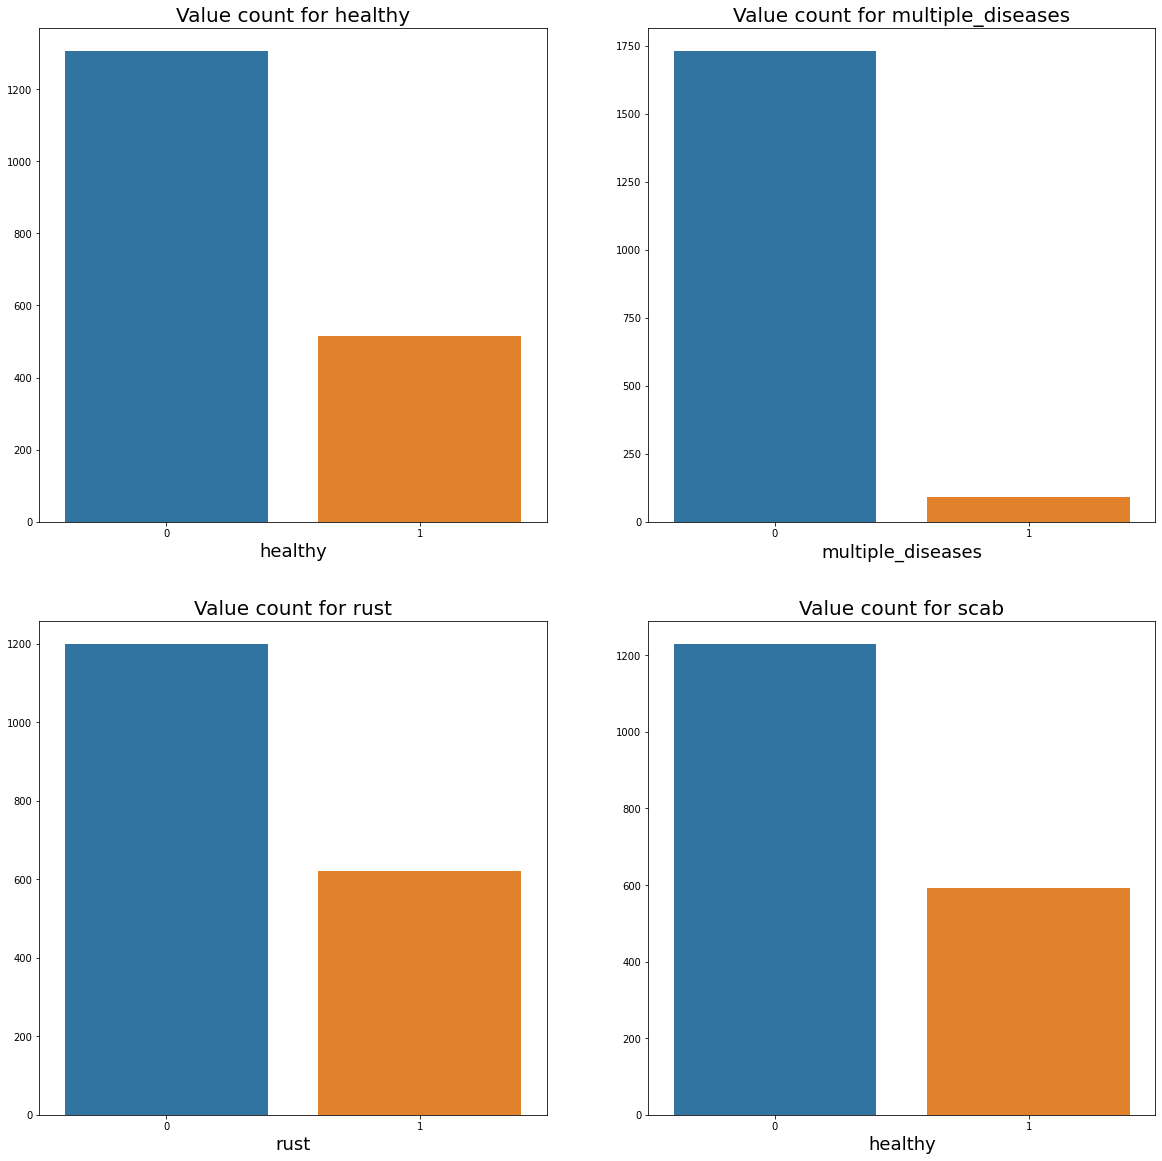

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(20,20))
sns.barplot(y=train.healthy.value_counts(),x=train.healthy.value_counts().index,ax=ax[0,0])
ax[0,0].set_title("Value count for healthy",size=20)
ax[0,0].set_xlabel('healthy',size=18)
ax[0,0].set_ylabel('',size=18)

sns.barplot(y=train.multiple_diseases.value_counts(),x=train.multiple_diseases.value_counts().index,ax=ax[0,1])
ax[0,1].set_title("Value count for multiple_diseases",size=20)
ax[0,1].set_xlabel('multiple_diseases',size=18)
ax[0,1].set_ylabel('',size=18)

sns.barplot(y=train.rust.value_counts(),x=train.rust.value_counts().index,ax=ax[1,0])
ax[1,0].set_title("Value count for rust",size=20)
ax[1,0].set_xlabel('rust',size=18)
ax[1,0].set_ylabel('',size=18)

sns.barplot(y=train.scab.value_counts(),x=train.scab.value_counts().index,ax=ax[1,1])
ax[1,1].set_title("Value count for scab",size=20)
ax[1,1].set_xlabel('scab',size=18)
ax[1,1].set_ylabel('',size=18)

In [ ]:
img=[]
filename=train.image_id
for file in filename:
    image=cv2.imread("/content/drive/My Drive/Data/plant/images/"+file)
    res=cv2.resize(image,(256,256))
    img.append(res)
img=np.array(img)

In [ ]:
print(img.shape)

(1821, 256, 256, 3)


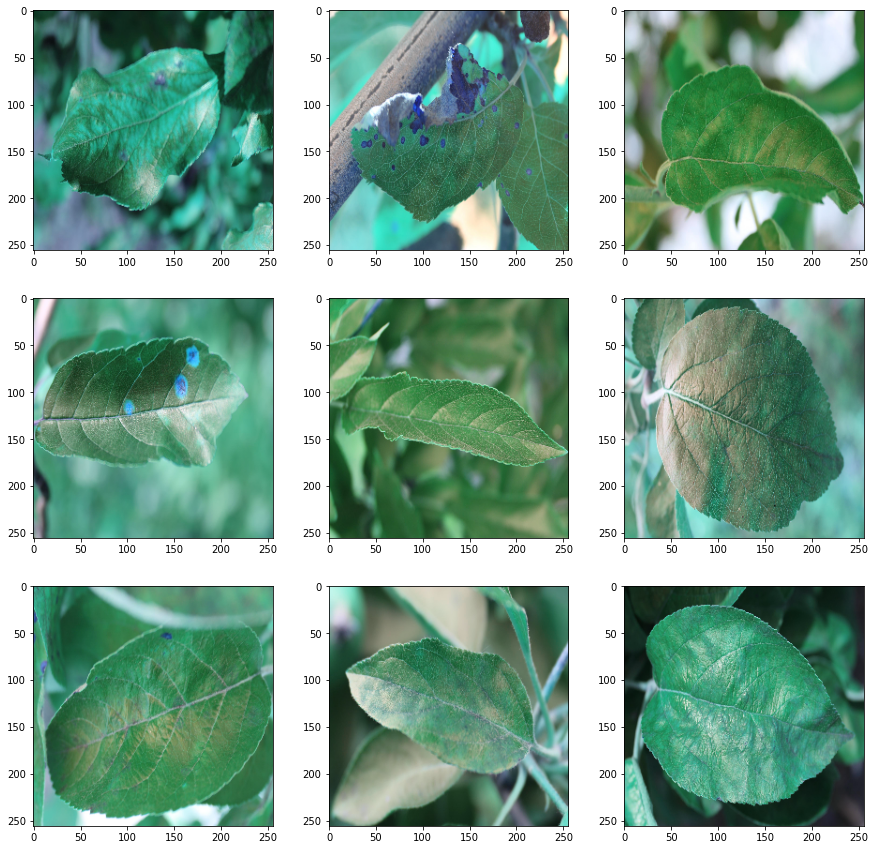

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(img[i])

### Visualize one leaf

In [ ]:
fig = px.imshow(cv2.resize(train_images[0], (205, 136)))
fig.show()

In [ ]:
red_values = [np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))]
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]

In [ ]:
fig = go.Figure()

for idx, values in enumerate([red_values, green_values, blue_values]):
    if idx == 0:
        color = "Red"
    if idx == 1:
        color = "Green"
    if idx == 2:
        color = "Blue"
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))
    
fig.update_layout(yaxis_title="Mean value", xaxis_title="Color channel",
                  title="Mean value vs. Color channel", template="plotly_white")

In [ ]:
fig = ff.create_distplot([red_values, green_values, blue_values],
                         group_labels=["R", "G", "B"],
                         colors=["red", "green", "blue"])
fig.update_layout(title_text="Distribution of channel values", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

Green is the most pronounced color, followed by red and blue respectively. The distributions, when plotted together, appear to have a similar shape, but shifted horizontally.

> The blue channel has the most uniform distribution out of the three color channels, with minimal skew (slight leftward skew). The blue channel shows great variation across images in the dataset.

>The red channel values seem to roughly normal distribution, but with a slight rightward (positive skew). This indicates that the red channel tends to be more concentrated at lower values, at around 100. There is large variation in average red values across images.

> The green channel values have a more uniform distribution than the red channel values, with a smaller peak. The distribution also has a leftward skew (in contrast to red) and a larger mode of around 140. This indicates that green is more pronounced in these images than red, which makes sense, because these are images of leaves!








In [ ]:
fig = go.Figure([go.Pie(labels=train_data.columns[1:],
           values=train_data.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Pie chart of targets", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

In the pie chart above, we can see that most leaves in the dataset are unhealthy (71.7%). Only 5% of plants have multiple diseases, and "rust" and "scab" occupy approximately one-third of the pie each.

## Image Processing

In [ ]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

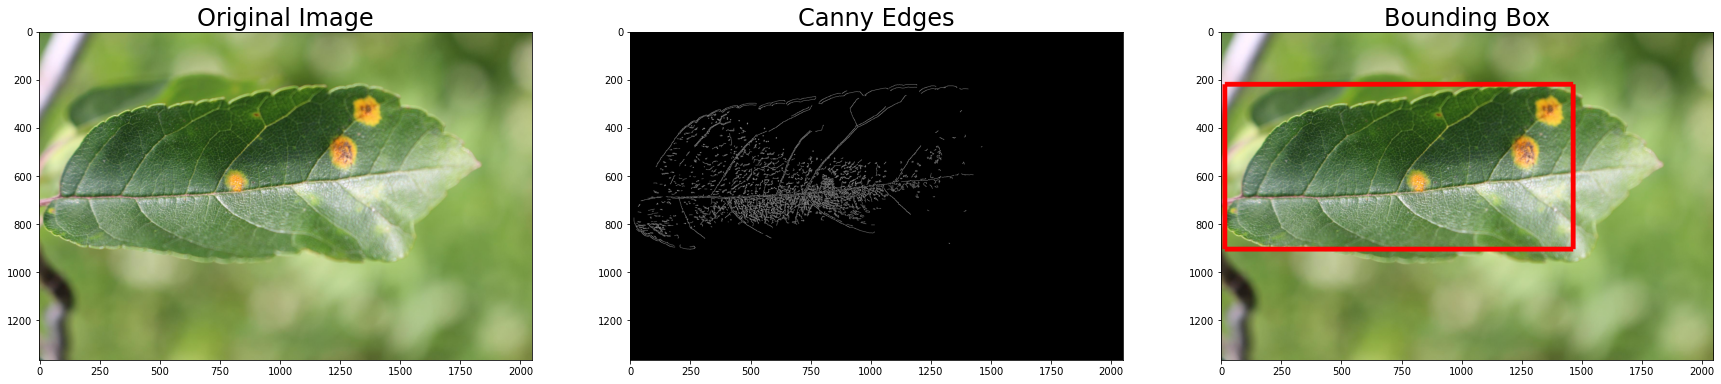

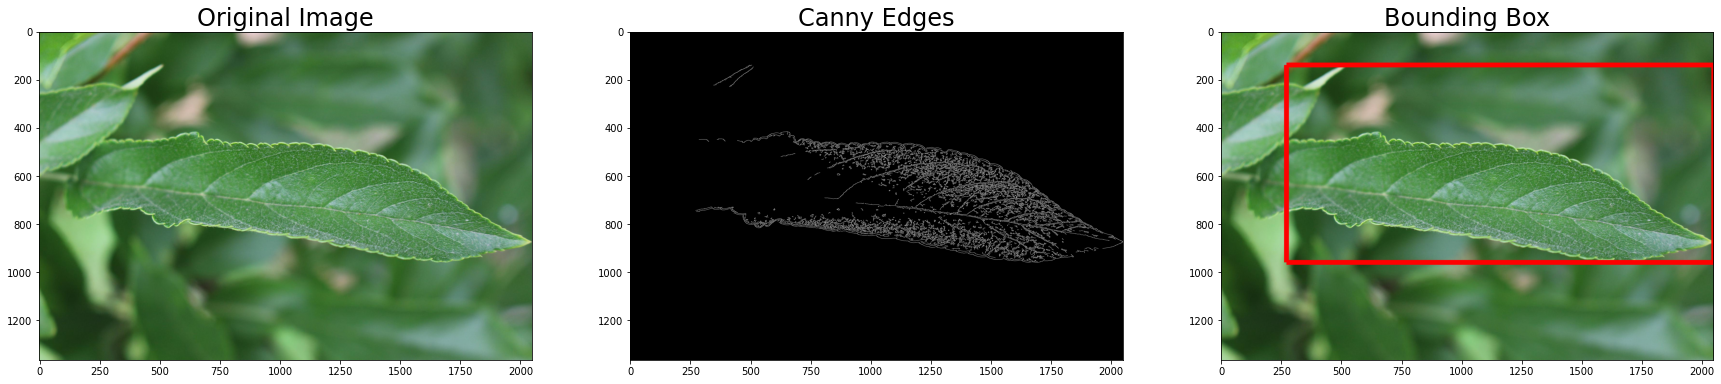

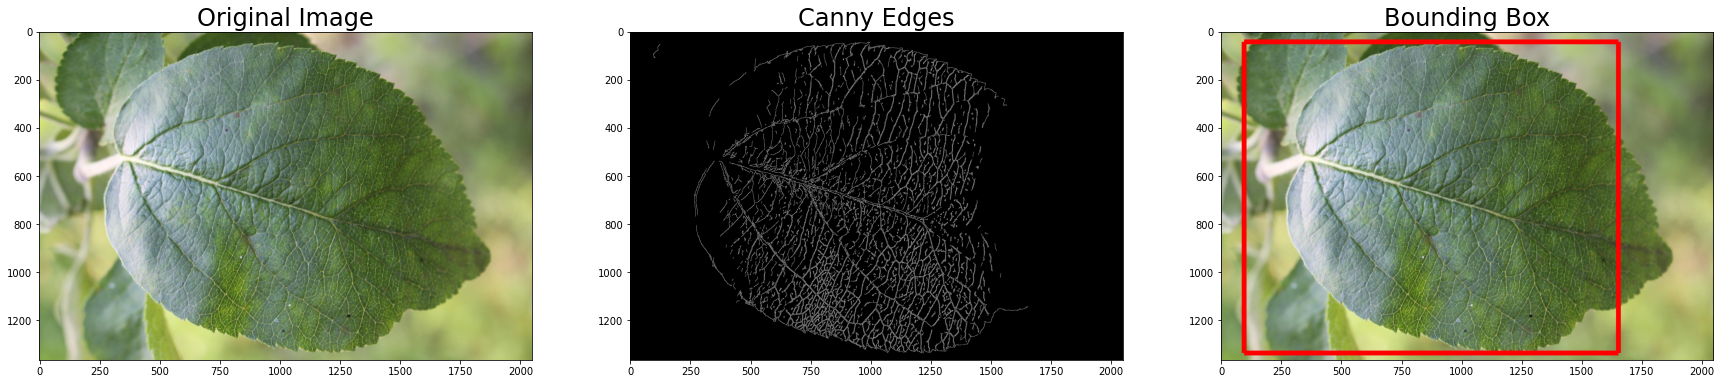

In [ ]:
edge_and_cut(train_images[3])
edge_and_cut(train_images[4])
edge_and_cut(train_images[5])

The second column of images above contains the Canny edges and the third column contains cropped images. I have taken the Canny edges and used it to predict a bounding box in which the actual leaf is contained. The most extreme edges at the four corners of the image are the vertices of the bounding box. This red box is likely to contain most of if not all of the leaf. These edges and bounding boxes can be used to build more accurate models.

# Modeling

#1. ResNet50

ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pre-trained version of the network trained on more than a million images from the ImageNet database. The pre-trained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals

In [ ]:
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values)

train, val = train_test_split(train, test_size = 0.15)

#### Create Dataset objects

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    fill_mode='nearest',
    shear_range=0.1,
    rescale=1/255,
    brightness_range=[0.5, 1.5])

In [ ]:
train_generator=train_datagen.flow_from_dataframe(train,directory='/content/drive/My Drive/Data/plant/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=32,
                                                  )

Found 1821 validated image filenames.


In [ ]:
val_generator=train_datagen.flow_from_dataframe(val,directory='/content/drive/My Drive/Data/plant/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                       subset='training',
                                                      batch_size=32)

Found 1547 validated image filenames.


In [ ]:
test_generator=train_datagen.flow_from_dataframe(test,directory='/content/drive/My Drive/Data/plant/images/',
                                                 target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=None,
                                                      class_mode=None,
                                                      shuffle=False,
                                                      batch_size=32)

Found 274 validated image filenames.


In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras import optimizers
model_finetuned = ResNet50(include_top=False, weights='imagenet', input_shape=(384,384,3))
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
model_finetuned.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 390, 390, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 192, 192, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 192, 192, 64) 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
from keras.callbacks import ReduceLROnPlateau

In [ ]:
history_1 = model_finetuned.fit_generator(train_generator,                                    
                                  steps_per_epoch=train_generator.samples//train_generator.batch_size,
                                  epochs=25,
                                  validation_data=val_generator, 
                                  validation_steps=val_generator.samples//val_generator.batch_size,
                                  verbose=1, 
                                  callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.000001)], use_multiprocessing=False, shuffle=True)  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/25
48/48 [==============================] - 126s 3s/step - loss: 0.3206 - accuracy: 0.8957 - val_loss: 10.2924 - val_accuracy: 0.2773
Epoch 2/25
48/48 [==============================] - 125s 3s/step - loss: 0.2793 - accuracy: 0.9076 - val_loss: 4.6848 - val_accuracy: 0.2773
Epoch 3/25
48/48 [==============================] - 125s 3s/step - loss: 0.2561 - accuracy: 0.9168 - val_loss: 1.7203 - val_accuracy: 0.2773
Epoch 4/25
48/48 [==============================] - 126s 3s/step - loss: 0.2641 - accuracy: 0.9069 - val_loss: 2.8712 - val_accuracy: 0.2773
Epoch 5/25
48/48 [==============================] - 125s 3s/step - loss: 0.2475 - accuracy: 0.9135 - val_loss: 1.7541 - val_accuracy: 0.3242
Epoch 6/25
48/48 [==============================] - 124s 3s/step - loss: 0.2350 - accuracy: 0.9281 - val_loss: 4.0232 - val_accuracy: 0.2773
Epoch 7/25
48/48 [==============================] - 125s 3s/step - loss: 0.2036 - accuracy: 0.9360 - val_loss: 5.2226 - val_accuracy: 0.2773
Epoch 8/25
4

## Predictions

[[4.4334104e-07 7.4810642e-01 2.5187761e-01 1.5494539e-05]]


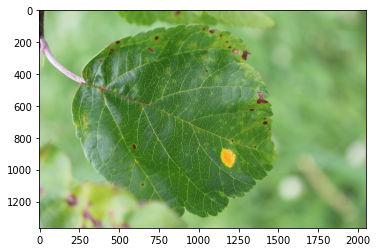

In [ ]:
from PIL import Image
import numpy as np

im=Image.open('/content/drive/My Drive/Data/plant/images/Train_170.jpg')
plt.imshow(im)
im=im.resize((384,384))
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
predictions = model_finetuned.predict(im)
print(predictions)
for i in predictions:
  

#### Saving the Trained Model

In [ ]:
model_finetuned.save('model.h5')
#model_finetuned_saved = load_model('model_finetuned.h5')

In [ ]:
model_finetuned.save('/content/drive/My Drive/Data/PP_ResNet50_model.h5')

### Plotting Accuracy Curves

In [ ]:
fig = go.Figure(data=[
    go.Line(name='train_acc', x=history_1.epoch, y=history_1.history['accuracy']),
    go.Line(name='Val_acc', x=history_1.epoch, y=history_1.history['val_accuracy'])])

fig.update_layout(
    title="Accuracy",
    xaxis_title="epoch",
    yaxis_title="accuracy",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ))
fig

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# 2. Efficient Net

EfficientNet is another popular (more recent) CNN-based ImageNet model which achieved the SOTA on several image-based tasks in 2019. EfficientNet performs model scaling in an innovative way to achieve excellent accuracy with significantly fewer parameters. It achieves the same if not greater accuracy than ResNet and DenseNet with a mcuh shallower architecture. Now let us train EfficientNet on leaf images and evaluate its performance.

In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 4.4MB/s 


In [ ]:
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
folder = "/content/drive/My Drive/Data/plant-pathology-2020-fgvc7"

In [ ]:
Y = pd.read_csv(os.path.join(folder,'train.csv'))
train_id = Y['image_id']
Y = Y[Y.columns[1:]] # remove image_id column
Y = Y.values # convert to array

In [ ]:
def image_resize(size, img_id):
    images=[]
    for i, name in enumerate(img_id):
        path=os.path.join(folder,'images',name+'.jpg')
        img=cv2.imread(path)
        image=cv2.resize(img,(size,size),interpolation=cv2.INTER_AREA)
        images.append(image)
        # print processing counter
        if i%200==0:
            print(i, 'images processed')
    return images


X = image_resize(100, train_id)
X = np.array(X)

0 images processed
200 images processed
400 images processed
600 images processed
800 images processed
1000 images processed
1200 images processed
1400 images processed
1600 images processed
1800 images processed


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
aug = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                          width_shift_range=0.2, # Range for random horizontal shifts
                          height_shift_range=0.2, # Range for random vertical shifts
                          zoom_range=0.2, # Range for random zoom
                          horizontal_flip=True, # Randomly flip inputs horizontally
                          vertical_flip=True) # Randomly flip inputs vertically

train_flow = aug.flow(X_train, Y_train, batch_size=32)

In [ ]:
def model(input_shape, classes):
    '''
    transfer learning from imagenet's weights, using Google's efficientnet7 architecture
    top layer (include_top) is removed as the number of classes is changed
    '''
    base = efn.EfficientNetB7(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

# each pic has been resized to 100x100, and with 3 channels (RGB)
input_shape = (100,100,3)
classes = 4
model = model(input_shape, classes)
model.summary()

258441216/258434480 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 4, 4, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________


In [ ]:
# for every epoch, the total original images will be augmented randomly
history=model.fit_generator(train_flow,
                    steps_per_epoch=32,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val, Y_val),
                    #use_multiprocessing=True,
                    workers=2)

Epoch 1/50
32/32 [==============================] - 33s 1s/step - loss: 0.0849 - accuracy: 0.9727 - val_loss: 0.2381 - val_accuracy: 0.9342
Epoch 2/50
32/32 [==============================] - 33s 1s/step - loss: 0.0978 - accuracy: 0.9653 - val_loss: 0.3210 - val_accuracy: 0.9233
Epoch 3/50
32/32 [==============================] - 33s 1s/step - loss: 0.1232 - accuracy: 0.9563 - val_loss: 0.5157 - val_accuracy: 0.9041
Epoch 4/50
32/32 [==============================] - 33s 1s/step - loss: 0.1061 - accuracy: 0.9603 - val_loss: 0.2641 - val_accuracy: 0.9123
Epoch 5/50
32/32 [==============================] - 33s 1s/step - loss: 0.1391 - accuracy: 0.9534 - val_loss: 0.4026 - val_accuracy: 0.9151
Epoch 6/50
32/32 [==============================] - 33s 1s/step - loss: 0.1093 - accuracy: 0.9633 - val_loss: 0.4563 - val_accuracy: 0.9151
Epoch 7/50
32/32 [==============================] - 33s 1s/step - loss: 0.0804 - accuracy: 0.9756 - val_loss: 0.4401 - val_accuracy: 0.8986
Epoch 8/50
32/32 [==

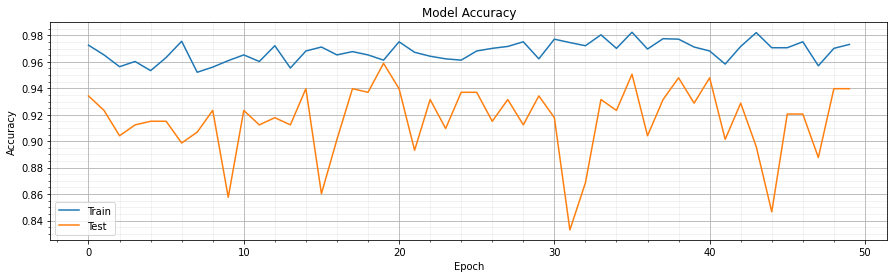

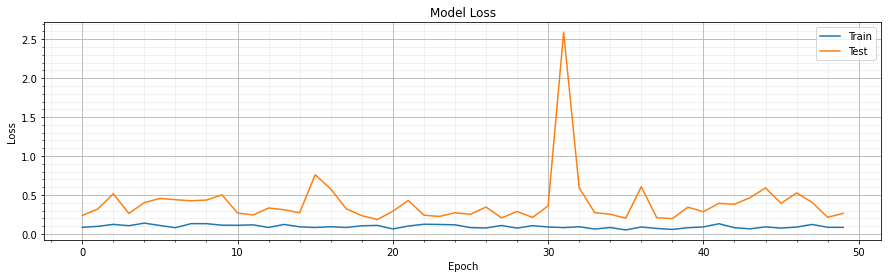

In [ ]:
def plot_validate(model, loss_acc):
    '''
    Plot model accuracy or loss for both train and test validation per epoch
    model : fitted model
    loss_acc : input 'loss' or 'acc' to plot respective graph
    '''
    history = model.history.history

    if loss_acc == 'loss':
        axis_title = 'loss'
        title = 'Loss'
        epoch = len(history['loss'])
    elif loss_acc == 'acc':
        axis_title = 'accuracy'
        title = 'Accuracy'
        epoch = len(history['loss'])

    plt.figure(figsize=(15,4))
    plt.plot(history[axis_title])
    plt.plot(history['val_' + axis_title])
    plt.title('Model ' + title)
    plt.ylabel(title)
    plt.xlabel('Epoch')

    plt.grid(b=True, which='major')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', alpha=0.2)
    plt.legend(['Train', 'Test'])
    plt.show()


plot_validate(model, 'acc')
plot_validate(model, 'loss')

In [ ]:
model.save('/content/drive/My Drive/Data/PP_Efn_model.h5')

In [ ]:
SUB_PATH = "/content/drive/My Drive/Data/plant/test_prediction.csv"

sub = pd.read_csv(SUB_PATH)
probs_RESNET = model_finetuned.predict(test_generator, verbose=1)
sub.loc[:, 'healthy':] = probs_RESNET
sub.to_csv('test_RESNET.csv', index=False)
sub.head()

57/57 [==============================] - 708s 13s/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,3.913862e-05,0.023928,9.760253e-01,7.802117e-06
1,Test_1,1.636779e-04,0.116001,8.837705e-01,6.453913e-05
2,Test_2,3.784251e-06,0.000150,5.507378e-09,9.998459e-01
3,Test_3,9.999189e-01,0.000076,2.614569e-06,2.215087e-06
4,Test_4,1.028306e-10,0.002969,9.970310e-01,1.097146e-11


##Conclusion

It can concluded that the ResNet model shows a better classification accuracy i.e., 97.49% on training set and 96.09% on validation set as compared to EfficientNet showing classification accuracy of 97.32% on Training set and 93.97% on validation set. Hence, ResNet model is used in GUI for implementation purpose.

##Future Scope

•	In future, the existing algorithms can also be utilized in outdoor conditions along with the combination of leaf front and leaf backs into a common dataset.

•	Further research can be devoted to model the detection and recognition 
techniques under mixed lighting conditions. It is of great importance to confirm that the accuracy of classification can be maintained under these conditions or not.

•	An unexplored combination of feature extraction, selection and learning methods can also be used to increase the effectiveness of detection and classification techniques.

•	The future work can also be dedicated to the automatic estimation of severity of the detected diseases.

•	Existing work can also be extended to achieve high speed and accuracy by developing the advanced algorithms.
